<a href="https://colab.research.google.com/github/lorenamaiorca/inteligenciaArtAva2023/blob/main/Entrega_3_IA2_Grupo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo redes Recursivas (LSTM o GRU) para clasificar (atributo clase discreto) o estimar (atributo clase continuo) usando Serie Temporal
Basado en https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import os
import csv

print("Librerías cargadas")

Librerías cargadas


In [2]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/Entrega1/'  #@param {type:"string"}


Mounted at /content/gdrive


In [27]:
#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'grupo2_entrega3_data.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = '|' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Yori, Xori, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Yori = np.array(df[attClase])
  Xori = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", Xori.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Yori.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
Xori = None
Yori = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  grupo2_entrega3_data.csv  cargado

> Cabecera: 
   Compras en supermercados en ARS  Compras en shopping en ARS  \
0                        25.994200                    5.886707   
1                        27.780007                    6.635468   
2                        27.858872                    6.366881   
3                        29.134272                    7.644786   
4                        27.969005                    7.244805   

   Total nafta y gasoil en ARS  IPC  
0                    28.496634  104  
1                    32.676969  106  
2                    31.653561  102  
3                    29.263343  109  
4                    31.543718  111  

> Características: 
       Compras en supermercados en ARS  Compras en shopping en ARS  \
count                        78.000000                   78.000000   
mean                        113.029072                   27.133620   
std                         100.410364                   31.049926   
min     

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo IPC como de entrada dado que es clase.

> Atributos entrada:  ['Compras en supermercados en ARS', 'Compras en shopping en ARS', 'Total nafta y gasoil en ARS']
	 X:  (78, 3)

> Atributo clase:  IPC
	 Y:  (78,)


In [28]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(Xori[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  Xori = scaler.fit_transform(Xori)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(Xori[:10])

10 primeros datos de Entrada antes de normalizar: 
[[25.99420017  5.88670666 28.49663441]
 [27.78000652  6.63546765 32.6769686 ]
 [27.85887208  6.36688079 31.65356104]
 [29.13427222  7.64478592 29.26334331]
 [27.96900468  7.24480458 31.54371849]
 [29.13271275  8.36161606 34.29878724]
 [31.18230246  9.51474003 34.19000219]
 [31.15488094  7.91820419 35.03214621]
 [30.5215062   7.76750991 34.33411461]
 [32.44598301  9.13701645 39.22050296]]


10 primeros datos de Entrada después de normalizar: 
[[-0.87240208 -0.68871131 -0.97354117]
 [-0.85450189 -0.66444048 -0.93109106]
 [-0.85371137 -0.67314663 -0.94148347]
 [-0.84092728 -0.63172378 -0.96575546]
 [-0.85260745 -0.64468904 -0.94259889]
 [-0.84094291 -0.60848798 -0.91462194]
 [-0.82039866 -0.57110987 -0.91572662]
 [-0.82067352 -0.62286102 -0.90717489]
 [-0.82702221 -0.62774572 -0.9142632 ]
 [-0.80773204 -0.58335365 -0.8646433 ]]


In [29]:
#@title Generar secuencia de datos como Serie

cantidad_intervalos_secuencia = 1 #@param {type:"integer"}

usar_atributos_secuencia = "Todos" #@param ["Solo atributo a Estimar", "Solo atributos de Entrada", "Todos"]

if cantidad_intervalos_secuencia < 1:
  cantidad_intervalos_secuencia = 1

# funciones auxilliares
def split_sequence(datosX, datosY, n_steps, atr_seq):
  x, y = [], []
  if len(datosX) != len(datosY):
    print("No coincide el largo de los datos X e Y!!!")
    return None, None
  for i in range(len(datosY)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(datosY)-1:
      break
    # gather input and output parts of the pattern
    if atr_seq == "Y":
      # sólo atributo a estimar (anteriores)
      seq_x = datosY[i:end_ix]
      seq_y = datosY[end_ix]
    elif atr_seq == "X":
      # sólo atributos de entrada (anteriores y actuales)
      seq_x = datosX[i:end_ix]
      seq_y = datosY[end_ix-1]
    else:
      # atributos de entrada y a estimar (anteriores)
      seq_xa = datosX[i:end_ix]
      seq_xb = datosY[i:end_ix]
      seq_y = datosY[end_ix]
      seq_x = []
      for xa, xb in zip(seq_xa, seq_xb):
        xa = list(xa)
        xa.append(xb)
        seq_x.append(xa)

    x.append( seq_x )
    y.append( seq_y )
  return np.array(x), np.array(y)

# muestra los primeros "cant" datos
def mostrarEjemplos(X, Y, cant=5):
  for i in range(min(len(X), cant)):
    print(X[i], Y[i])
  print("\n")

print("\n> Antes de generar serie: ")
mostrarEjemplos(Xori, Yori)

# genera secuencias
print("> Generando series con ", cantidad_intervalos_secuencia ," intervalos ")
if (Xori.shape[1] == 0) or usar_atributos_secuencia == "Solo atributo a Estimar":
  atrSeq = "Y"
  cant_atributos_entrada = 1
elif usar_atributos_secuencia == "Solo atributos de Entrada":
  atrSeq = "X"
  cant_atributos_entrada = Xori.shape[1]
else: # "Todos"
  atrSeq = "XY"
  cant_atributos_entrada = Xori.shape[1] + 1
X, Y = split_sequence(Xori, Yori, cantidad_intervalos_secuencia, atrSeq)

print("\n> Después de generar serie: ")
mostrarEjemplos(X, Y)



> Antes de generar serie: 
[-0.87240208 -0.68871131 -0.97354117] 104
[-0.85450189 -0.66444048 -0.93109106] 106
[-0.85371137 -0.67314663 -0.94148347] 102
[-0.84092728 -0.63172378 -0.96575546] 109
[-0.85260745 -0.64468904 -0.94259889] 111


> Generando series con  1  intervalos 

> Después de generar serie: 
[[ -0.87240208  -0.68871131  -0.97354117 104.        ]] 106
[[ -0.85450189  -0.66444048  -0.93109106 106.        ]] 102
[[ -0.85371137  -0.67314663  -0.94148347 102.        ]] 109
[[ -0.84092728  -0.63172378  -0.96575546 109.        ]] 111
[[ -0.85260745  -0.64468904  -0.94259889 111.        ]] 112




In [30]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "continuo - ESTIMACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# reshape de [cant ejemplos, datos entrada] into [cant ejemplos, intervalos, datos entrada]
X =  X.reshape((X.shape[0], cantidad_intervalos_secuencia, cant_atributos_entrada))

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, intervalos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, intervalos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de ESTIMACIÓN 


> Para Entrenamiento: 
 - x_train (cant ejemplos, intervalos, datos entrada):  (57, 1, 4)
 - y_train (cant):  57

 Para Prueba: 
 - x_test (cant ejemplos, intervalos, datos entrada):  (20, 1, 4)
 - y_test (cant):  20


-- recordar que al no usar rnn_func_activation con tanh puede ser que no se use GPU (ver requerimientos en https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
-- se considera salida lineal porque es problema de Estimación!
Modelo creado con  6  capas:
Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1, 4)]            0         
                                                                 
 stacked_1 (GRU)             (None, 1, 150)            70200     
                                                                 
 stacked_2 (GRU)             (None, 150)               135900    
                                                                 
 flat (Flatten)              (None, 150)               0         
                                                                 
 d_1 (Dropout)               (None, 150)               0      

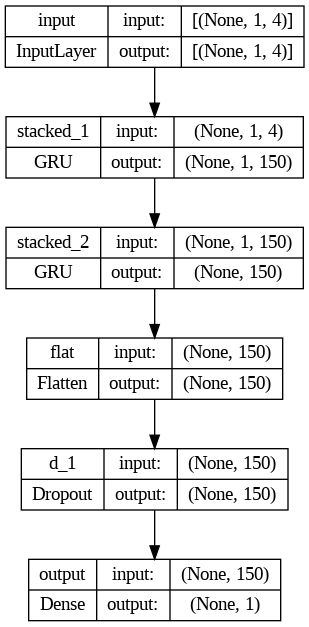

In [31]:
#@title Establecer modelo

#@markdown ### Parámetros de las capas RNN:

rnn_tipo_red = "Stacked" #@param ["Simple", "Stacked", "Bidirectional", "Bidirectional Stacked"]
rnn_tipo_capa = "GRU" #@param ["LSTM", "GRU"]
rnn_cant_neuronas = 150 #@param {type: "integer"}
rnn_func_activation = "relu" #@param ["tanh", "relu"]
rnn_porc_capa_DropOut = 0.0 #@param {type:"number"}

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = 'D' #@param {type:"string"}
#@markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_porc_capa_DropOut = 0.4 #@param {type:"number"}

#@markdown ### Parámetros de la capa de Salida:
red_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.001 #@param {type: "number"}


## aplicación de los parámetros elegidos

if rnn_func_activation == "relu":
  print("-- recordar que al no usar rnn_func_activation con tanh puede ser que no se use GPU (ver requerimientos en https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)")

# chequea configuración de drop out
if lineal_porc_capa_DropOut <= 0:
  lineal_porc_capa_DropOut = 0.10
elif lineal_porc_capa_DropOut > 0.9:
    lineal_porc_capa_DropOut = 0.9
if rnn_porc_capa_DropOut <= 0:
  rnn_porc_capa_DropOut = 0.00
elif rnn_porc_capa_DropOut > 0.9:
    rnn_porc_capa_DropOut = 0.9

# cantidad de neuronas ocultas
hidden_layers = []
for val in lineal_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  if val == "D":
    hidden_layers.append( "DropOut" )
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if esProblemaClasificacion:
  tipo_output_softMax = (red_tipo_capa_salida[:7] == 'softmax')
else:
  print("-- se considera salida lineal porque es problema de Estimación!")
  tipo_output_softMax = False

if rnn_cant_neuronas < 5:
  rnn_cant_neuronas = 5


if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente

# agrega capas de entrada y encoding  para datos de entrada
inputLay = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]), name="input")
eachLay = inputLay

# agrega capas RNN
# nota ojo que si se usa activation='relu' no utiliza GPU!
if rnn_tipo_red == "Simple":
  # una capa
  if rnn_tipo_capa == "LSTM":
    eachLay = tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="simple")(eachLay)
  else:
    eachLay = tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="simple")(eachLay)

elif rnn_tipo_red == "Stacked":
  # dos capas
  if rnn_tipo_capa == "LSTM":
    eachLay = tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, return_sequences=True, dropout=rnn_porc_capa_DropOut, name="stacked_1")(eachLay)
    eachLay = tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="stacked_2")(eachLay)
  else:
    eachLay = tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, return_sequences=True, dropout=rnn_porc_capa_DropOut, name="stacked_1")(eachLay)
    eachLay = tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="stacked_2")(eachLay)

elif rnn_tipo_red == "Bidirectional":
  # una capa bidireccional
  if rnn_tipo_capa == "LSTM":
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="LSTM"),  name="bdirecc")(eachLay)
  else:
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="GRU"), name="bdirecc")(eachLay)

elif rnn_tipo_red == "Bidirectional Stacked":
  # dos capa bidireccional
  if rnn_tipo_capa == "LSTM":
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, return_sequences=True, dropout=rnn_porc_capa_DropOut, name="LSTM_1"),  name="bdirecc_stacked_1")(eachLay)
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="LSTM_2"),  name="bdirecc_stacked_2")(eachLay)
  else:
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, return_sequences=True, dropout=rnn_porc_capa_DropOut, name="GRU_1"), name="bdirecc_stacked_1")(eachLay)
    eachLay = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_cant_neuronas, activation=rnn_func_activation, dropout=rnn_porc_capa_DropOut, name="GRU_2"), name="bdirecc_stacked_2")(eachLay)

else:
  print("Tipo de red inválida: ", rnn_tipo_red, "!!!")

if len(hidden_layers) > 0:
  eachLay = tf.keras.layers.Flatten(name="flat")(eachLay)

# agrega capas lineales
auxName = 'lineal_'
auxId = 1
for val_hid in hidden_layers:

  if val_hid == "DropOut":
    auxlayerName = "d_"+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dropout(lineal_porc_capa_DropOut,name=auxlayerName)(eachLay)
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn_"+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dense(int(val_hid), name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if tipo_output_softMax:
    # se genera una capa softmax
    outputLay = tf.keras.layers.Dense(units = len(CLASES), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    outputLay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay) # capa de salida

# genera el modelo
model = keras.Model(
    inputs=inputLay,
    outputs=outputLay,
    name="RNN")

# genera el modelo
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    if esProblemaClasificacion:
      model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    else:
      model.compile(optimizer=opt, loss='mse', metrics=['RootMeanSquaredError'])


print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


In [32]:
#@title Entrenar

cant_epocas_entrenamiento = 500 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

activar_corte_por_estabilidad_error_val = False #@param {type:"boolean"}

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train,
                                       (y_trainEnc if tipo_output_softMax else y_train),
                                       test_size=0.1)


print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_error_val:
  # se agrega un callBack para que corte
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=0,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas,
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr )

print("\n>Entrenamiento Finalizado.")



> De los  57 ejemplos de entrenamiento: 
            se usan  51 ejemplos para entrenar 
            y  6 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/500
2/2 [==============================] - 5s 473ms/step - loss: 323046.4062 - root_mean_squared_error: 568.3717 - val_loss: 62864.9180 - val_root_mean_squared_error: 250.7288
Epoch 2/500
2/2 [==============================] - 0s 43ms/step - loss: 307328.9688 - root_mean_squared_error: 554.3726 - val_loss: 59833.5625 - val_root_mean_squared_error: 244.6090
Epoch 3/500
2/2 [==============================] - 0s 38ms/step - loss: 297302.1250 - root_mean_squared_error: 545.2542 - val_loss: 56847.1406 - val_root_mean_squared_error: 238.4264
Epoch 4/500
2/2 [==============================] - 0s 57ms/step - loss: 280222.1562 - root_mean_squared_error: 529.3602 - val_loss: 53924.0352 - val_root_mean_squared_error: 232.2155
Epoch 5/500
2/2 [==============================] - 0s 57ms/step - loss: 263691.9688 - root_mean_squared_err

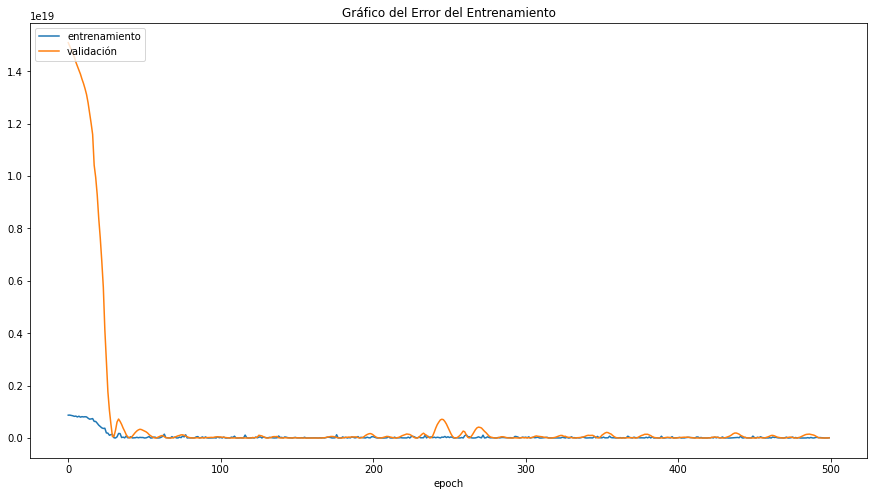

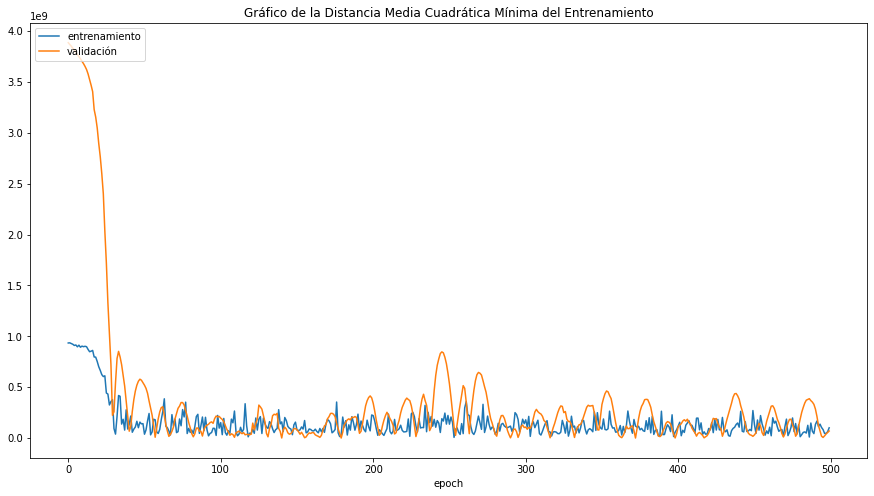

In [ ]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8))
if esProblemaClasificacion:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Gráfico de la Exactitud del Entrenamiento')
else:
  plt.plot(history.history['root_mean_squared_error'])
  plt.plot(history.history['val_root_mean_squared_error'])
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')

plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

*** Resultados con datos de Entrenamiento: 


	 Real 			 Estimado 		 Error Absoluto 	 Error Relativo
	  133.00 		   129.19 		     3.81 		     2.87%
	  149.00 		   144.87 		     4.13 		     2.77%
	  402.00 		   395.87 		     6.13 		     1.53%
	  119.00 		   116.82 		     2.18 		     1.83%
	  547.00 		   542.39 		     4.61 		     0.84%
	  184.00 		   181.19 		     2.81 		     1.53%
	  793.00 		   776.17 		    16.83 		     2.12%
	  174.00 		   165.58 		     8.42 		     4.84%
	  498.00 		   496.54 		     1.46 		     0.29%
	  561.00 		   562.64 		     1.64 		     0.29%
	  111.00 		   107.55 		     3.45 		     3.11%
	  633.00 		   622.26 		    10.74 		     1.70%
	  114.00 		   110.68 		     3.32 		     2.91%
	  206.00 		   198.77 		     7.23 		     3.51%
	  121.00 		   117.95 		     3.05 		     2.52%
	  296.00 		   295.73 		     0.27 		     0.09%
	  102.00 		   104.45 		     2.45 		     2.41%
	  130.00 		   126.15 		     3.85 		     2.96%
	  165.00 		   155.22 		     9.78 		     5.93%
	  315

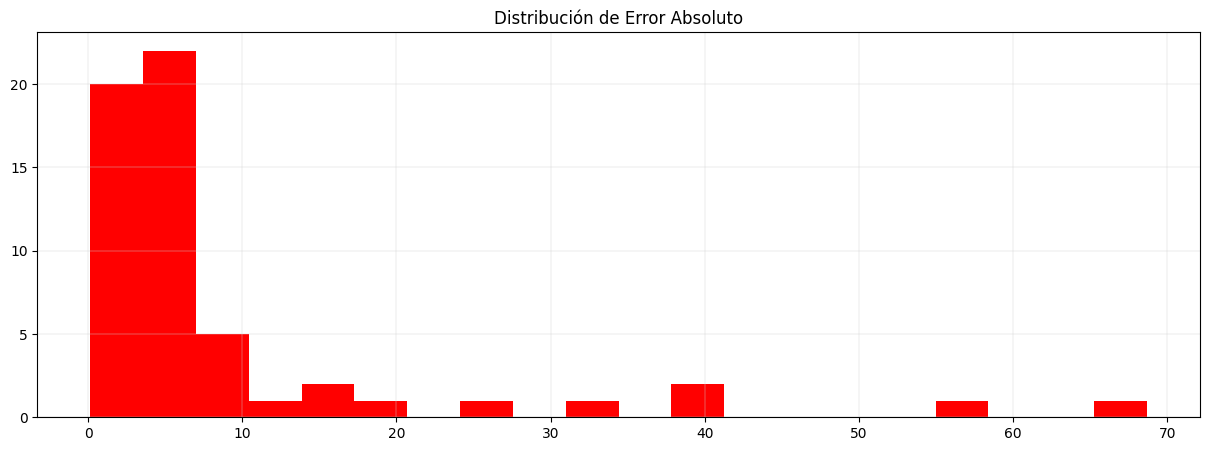


 Error Relativo: 
            Mínimo: 0.04% 
            Promedio: 2.21 ± 1.49
            Máximo: 7.94% 


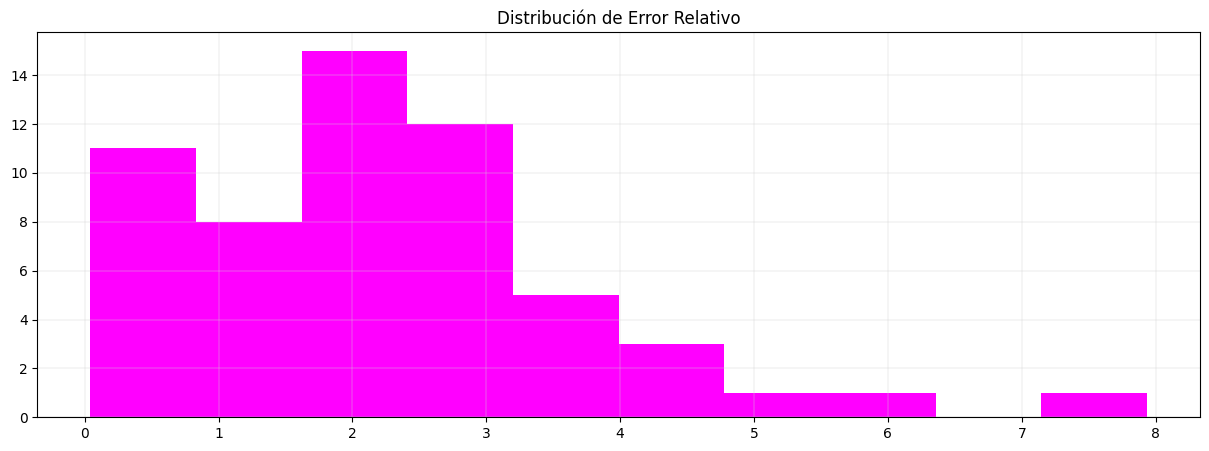

In [33]:
#@title Evaluar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = True #@param {type:"boolean"}

# función auxiliar para el cálculo de error
def calcErrores(pred, real, mostrarDetalle=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    print("\n")
    print("\t Real \t\t\t Estimado \t\t Error Absoluto \t Error Relativo")

  for pV, r in zip(pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        print("\t{:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f}%".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(estimVals, y, detalle)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    # muestra los resultados con las imágenes
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + str(clReal) + ' / Modelo(RNA): '
        strTitulo = strTitulo + str(clPred) + ' (' + str( idclPred ) +')'
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión: ')
    plt.xlabel('Real')
    plt.ylabel('Modelo')
    plt.scatter(classReal, classPreds)

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, mostrar_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:


>Evaluación del Modelo: 
    - Error:  437.249
    - Distancia Media Cuadrática Mínima:  20.911


*** Resultados con datos de Prueba: 


	 Real 			 Estimado 		 Error Absoluto 	 Error Relativo
	  310.00 		   311.97 		     1.97 		     0.63%
	  484.00 		   480.69 		     3.31 		     0.68%
	 1079.00 		  1062.97 		    16.03 		     1.49%
	  322.00 		   320.83 		     1.17 		     0.36%
	  454.00 		   447.27 		     6.73 		     1.48%
	  676.00 		   651.33 		    24.67 		     3.65%
	  190.00 		   185.78 		     4.22 		     2.22%
	 1614.00 		  1548.94 		    65.06 		     4.03%
	  852.00 		   818.08 		    33.92 		     3.98%
	  226.00 		   222.87 		     3.13 		     1.38%
	 1029.00 		   997.68 		    31.32 		     3.04%
	  155.00 		   149.05 		     5.95 		     3.84%
	 1203.00 		  1175.30 		    27.70 		     2.30%
	  145.00 		   139.63 		     5.37 		     3.70%
	  371.00 		   367.83 		     3.17 		     0.85%
	  436.00 		   426.09 		     9.91 		     2.27%
	  717.00 		   696.31 		    20.69 		     2.89%
	  469.0

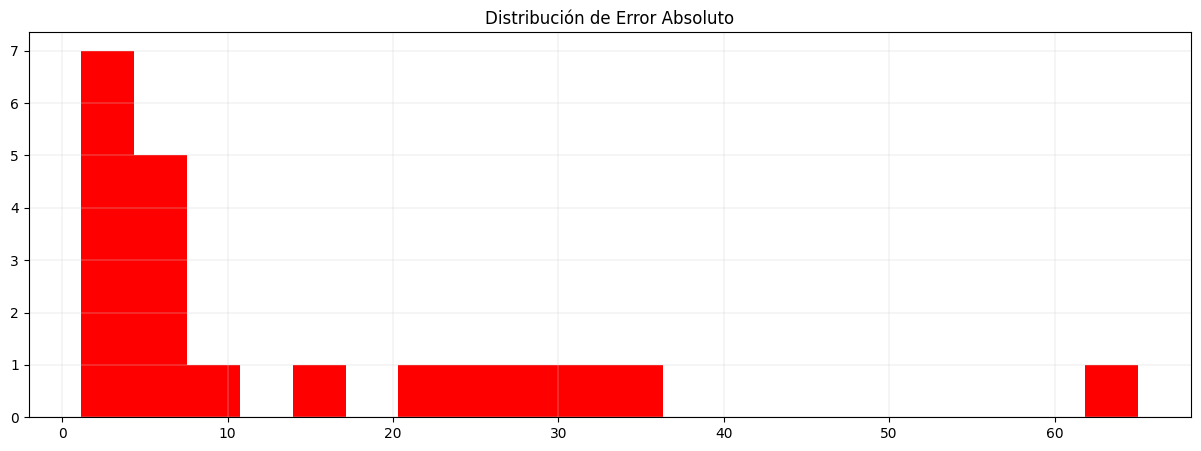


 Error Relativo: 
            Mínimo: 0.36% 
            Promedio: 2.28 ± 1.26
            Máximo: 4.03% 


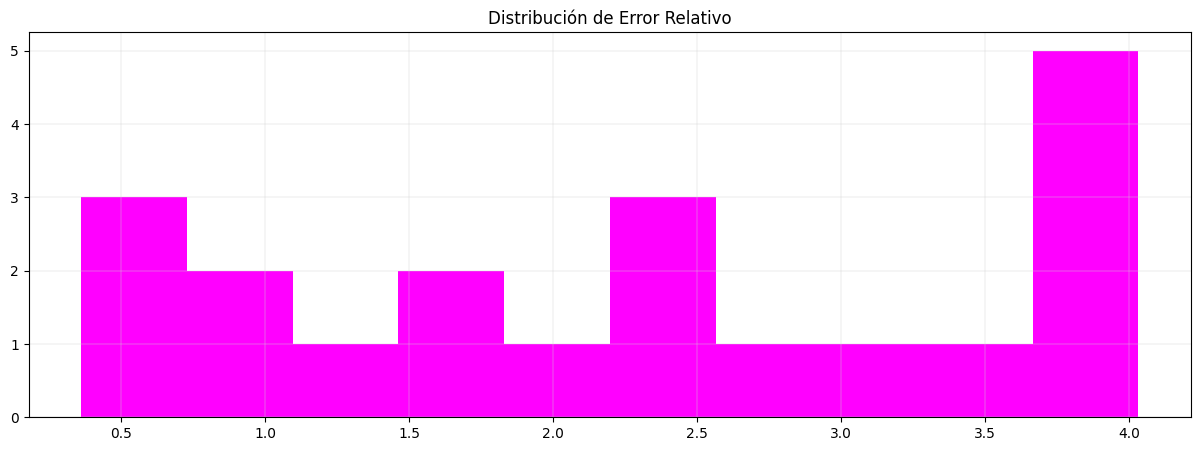

In [34]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}

  # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test), verbose=0)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", round(resEval[0],3))
if esProblemaClasificacion:
  print("    - Exactitud: ", round(resEval[1]*100,2))
else:
  print("    - Distancia Media Cuadrática Mínima: ", round(resEval[1],3))

#print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, mostrar_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba)
